In [2]:
!pip  install shap

     |████████████████████████████████| 564 kB 5.0 MB/s 


In [9]:
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from sklearn.metrics import confusion_matrix
from scipy.sparse.construct import rand
import random
import pickle
import shap
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Load Data

In [10]:
df = pd.read_csv('/content/gdrive/MyDrive/dataset/Wednesday-workingHours.pcap_ISCX.csv')
print(len(df))
display(df.head())

692703


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,38308,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,389,479,11,5,172,326,79,0,15.636364,31.449238,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1095,10,6,3150,3150,1575,0,315.000000,632.561635,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,389,15206,17,12,3452,6660,1313,0,203.058823,425.778474,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,1092,9,6,3150,3152,1575,0,350.000000,694.509719,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


### Data Preprocessing

In [11]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace = True)

In [12]:
df[' Label'].value_counts()

BENIGN              439683
DoS Hulk            230124
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name:  Label, dtype: int64

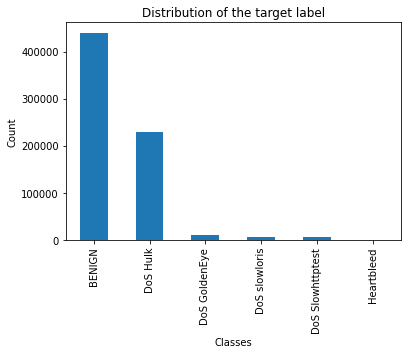

In [13]:
df[' Label'].value_counts().plot(kind='bar');
plt.title('Distribution of the target label')
plt.xlabel('Classes')
plt.ylabel('Count');

In [14]:
df[' Label'].replace({"DoS Hulk": 1,
                      "DoS GoldenEye": 1,
                      "DoS slowloris": 1,
                      "DoS Slowhttptest": 1,
                      "Heartbleed": 1,
                      "BENIGN": 0
                     }, inplace=True)
df[' Label'].value_counts()

0    439683
1    251723
Name:  Label, dtype: int64

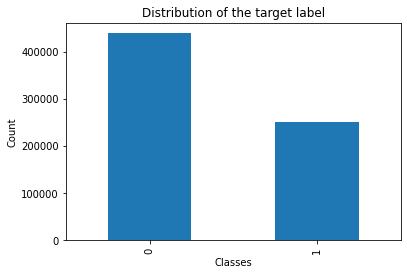

In [15]:
df[' Label'].value_counts().plot(kind='bar');
plt.title('Distribution of the target label')
plt.xlabel('Classes')
plt.ylabel('Count');

In [16]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

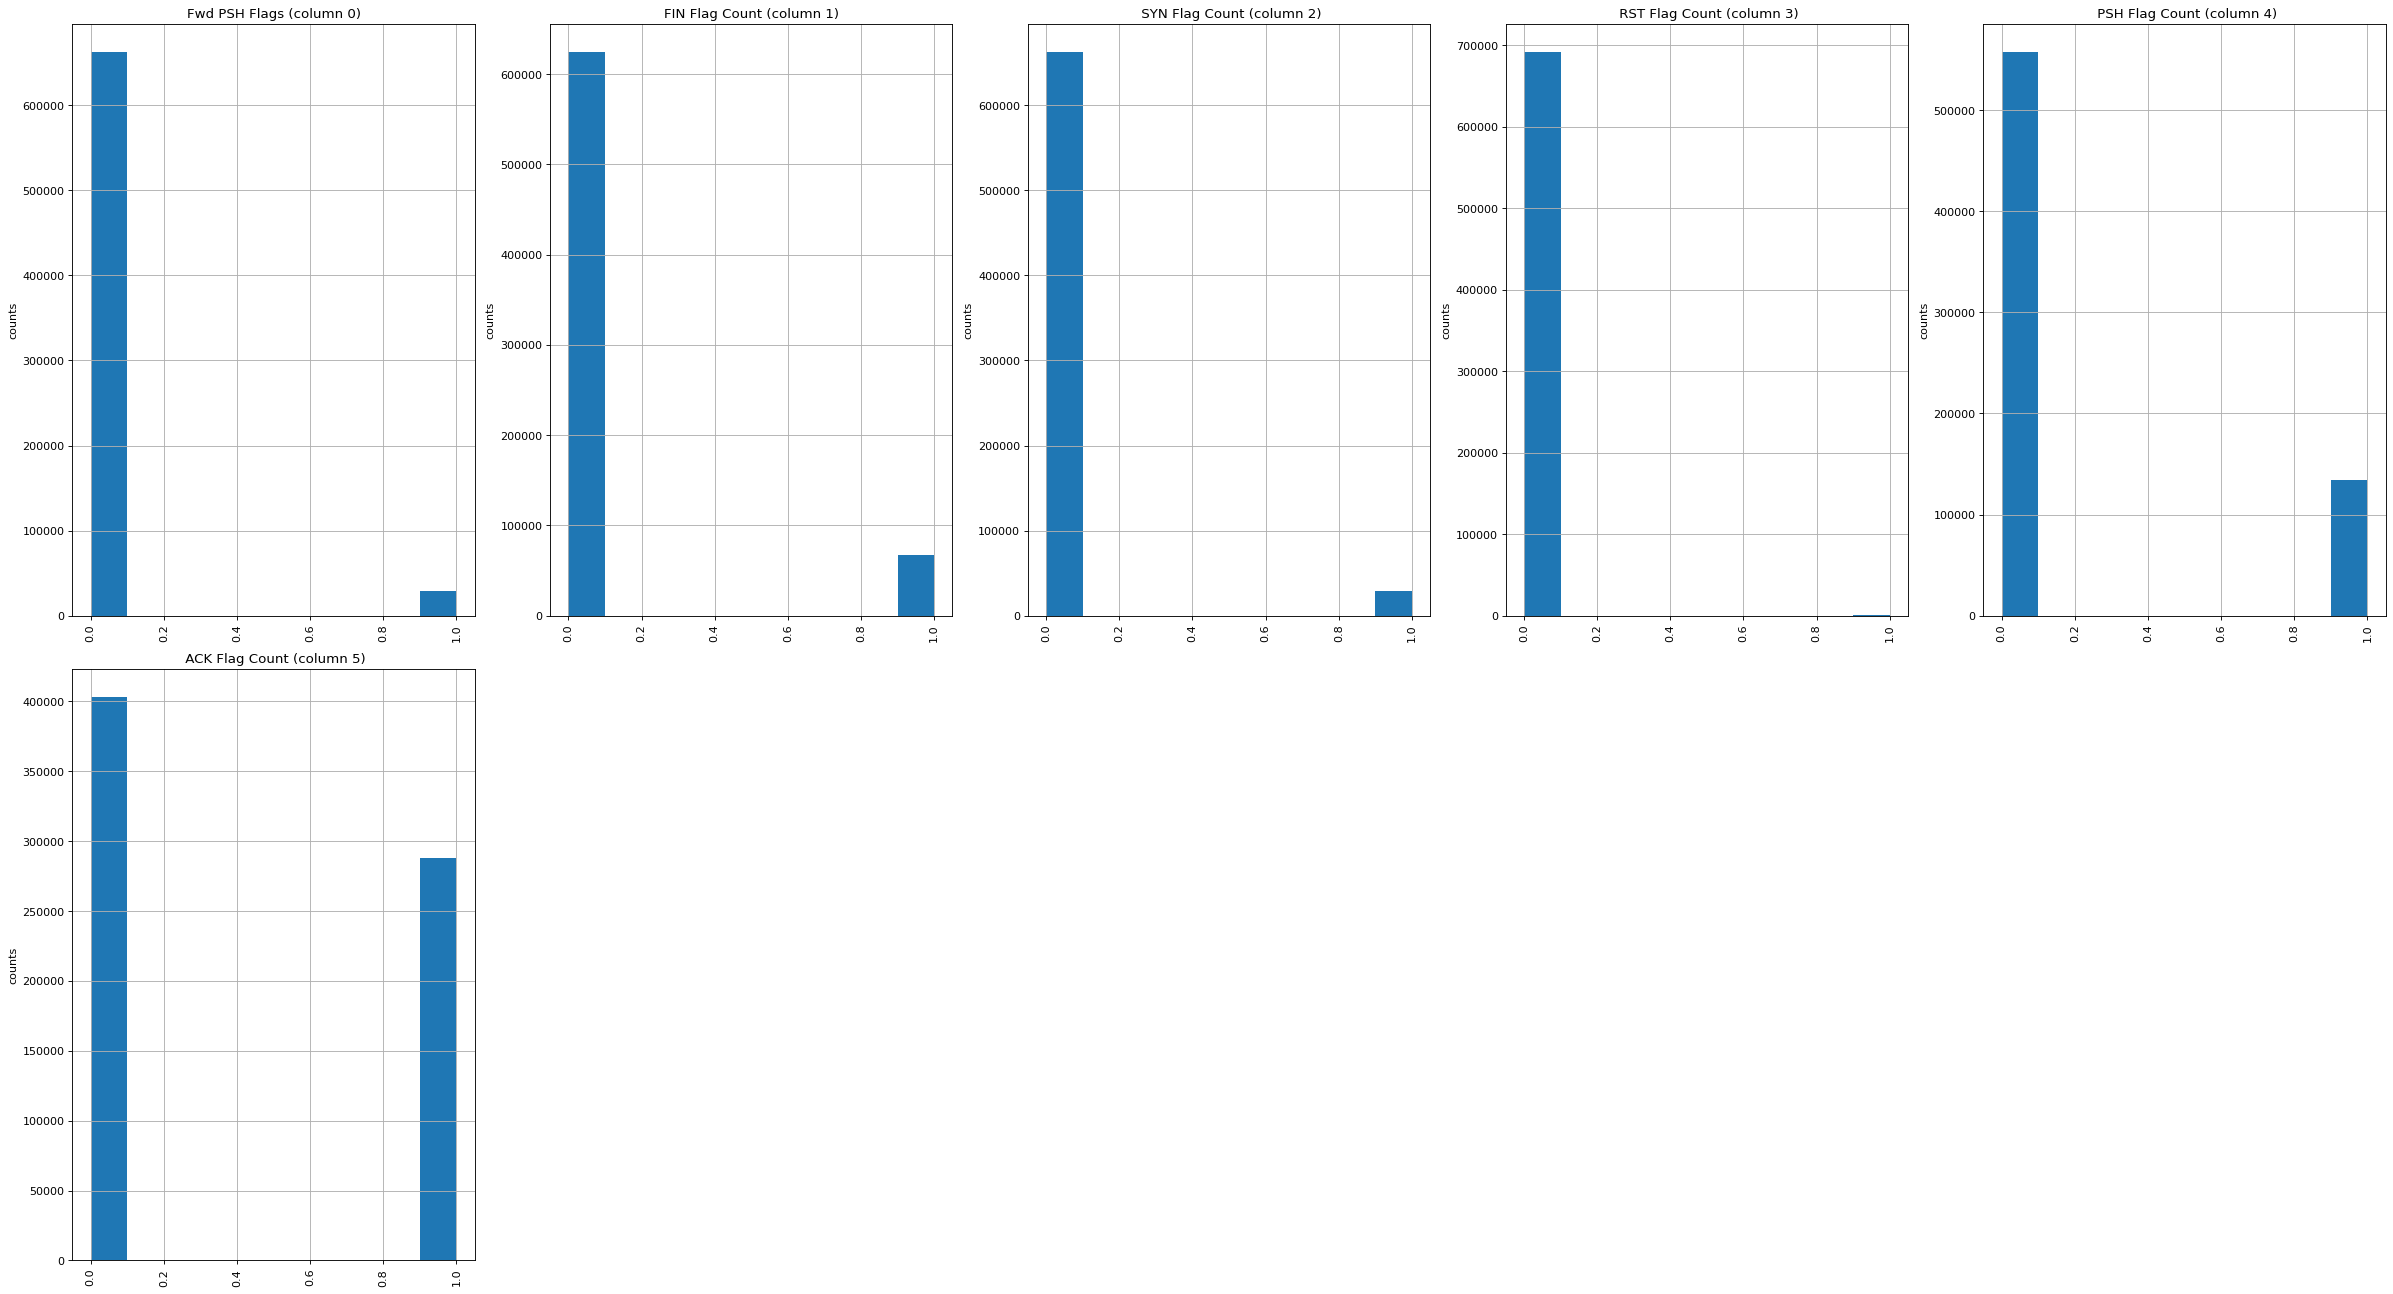

In [ ]:
plotPerColumnDistribution(df, 6, 5)

In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = 'Wednesday-workingHours.pcap_ISCX'
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


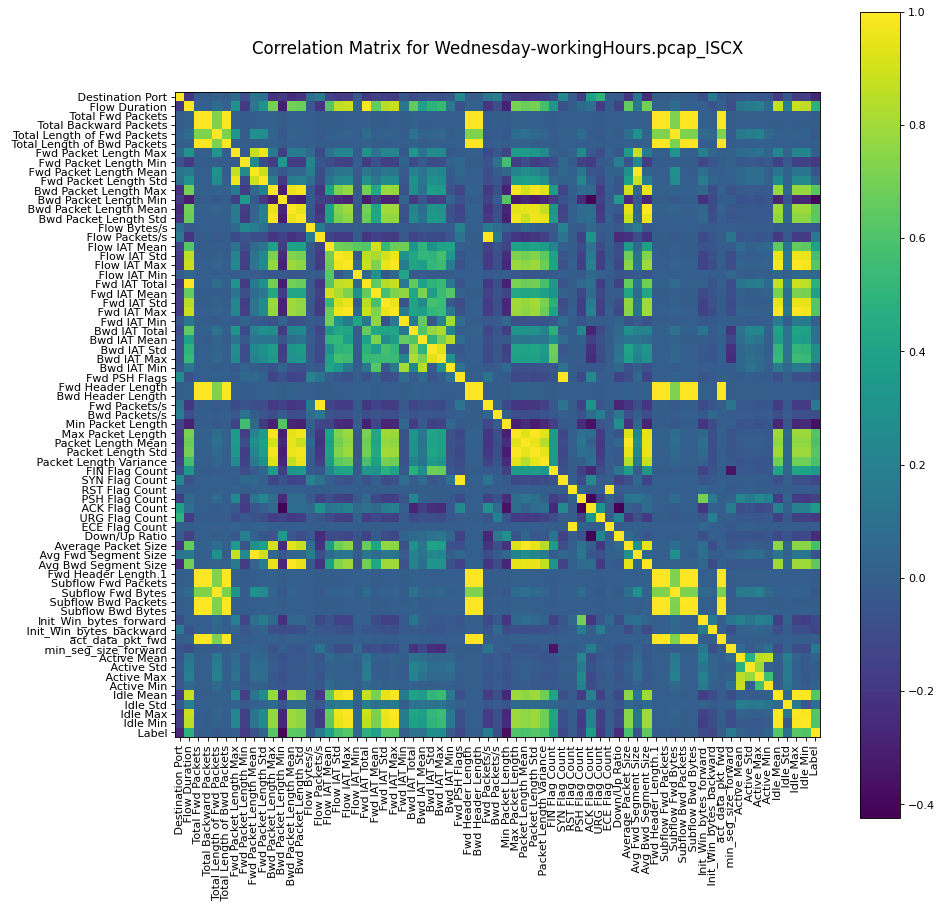

In [ ]:
plotCorrelationMatrix(df, 13)

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

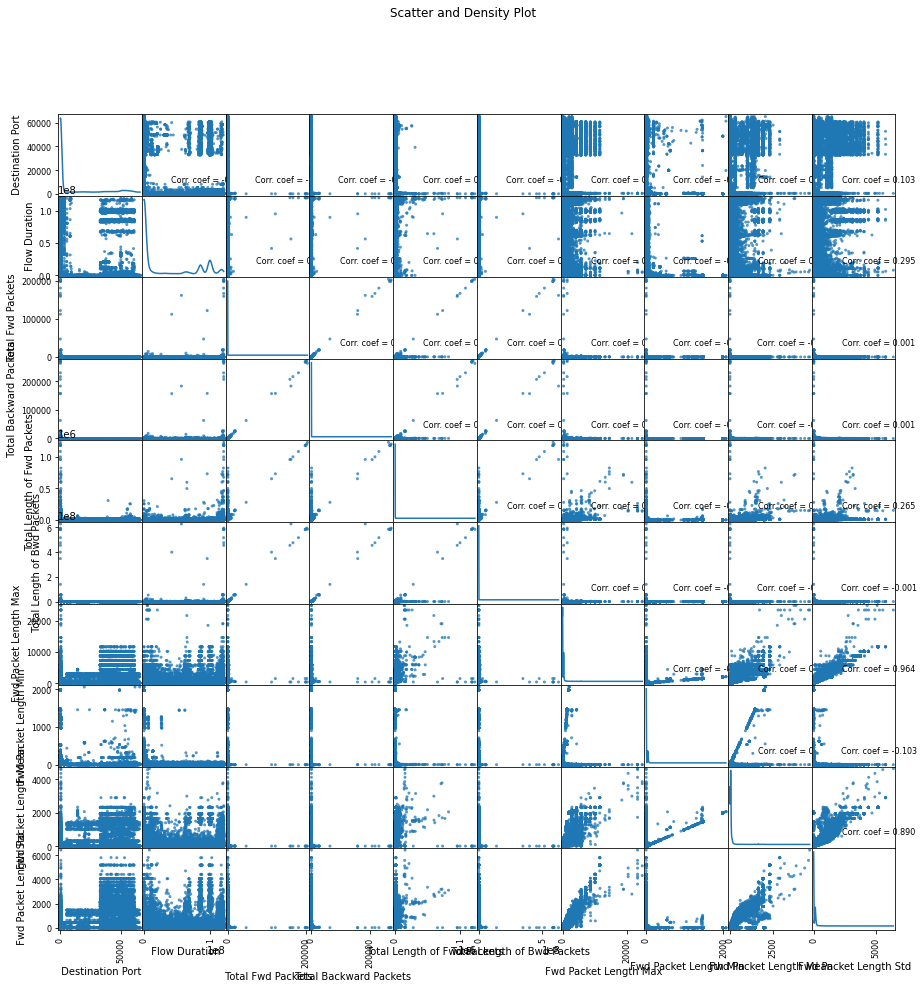

In [ ]:
plotScatterMatrix(df, 15, 8)

### Feature Engineering

In [ ]:
X = df.drop(columns=[' Label'])
y = df[' Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=123)

Test Accuracy = 0.9994648616595074
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87827
           1       1.00      1.00      1.00     50455

    accuracy                           1.00    138282
   macro avg       1.00      1.00      1.00    138282
weighted avg       1.00      1.00      1.00    138282



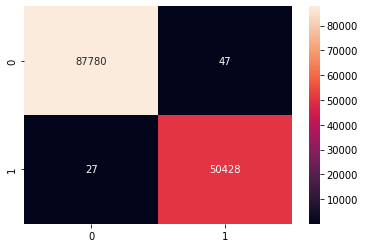

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test Accuracy = {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
# load JS visualization code to notebook
shap.initjs()

In [ ]:
XX = X.sample(n=10000)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(XX)

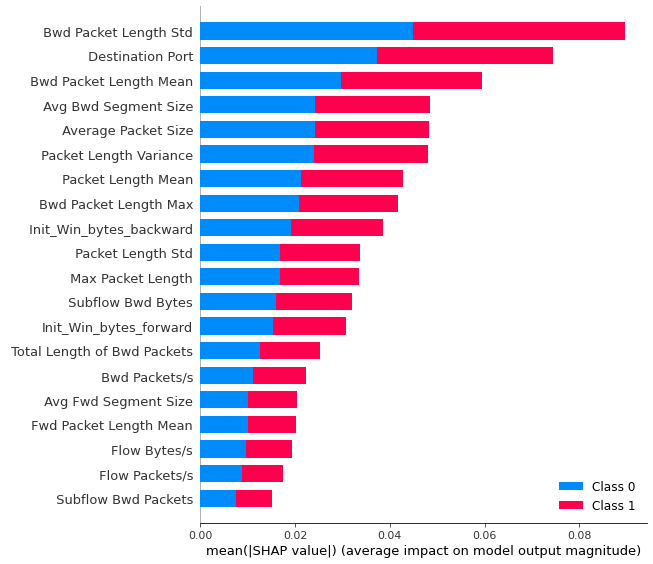

In [ ]:
shap.summary_plot(shap_values, features=XX, feature_names=XX.columns, plot_type='bar')

### Model Comparsion

In [17]:
X = df[[' Bwd Packet Length Std', ' Destination Port', ' Bwd Packet Length Mean', ' Avg Bwd Segment Size',
        ' Average Packet Size', ' Packet Length Variance', ' Packet Length Mean', 'Bwd Packet Length Max',
        ' Init_Win_bytes_backward', ' Packet Length Std']].values
y = df[' Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=123)

#### Random Forest

Test Accuracy = 0.9967168539650858
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87827
           1       0.99      1.00      1.00     50455

    accuracy                           1.00    138282
   macro avg       1.00      1.00      1.00    138282
weighted avg       1.00      1.00      1.00    138282



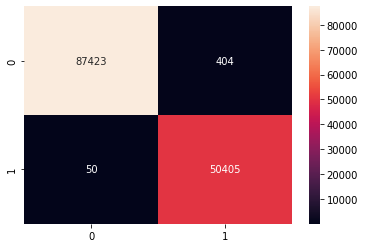

In [18]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print("Test Accuracy = {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

#### Decision Tree

Test Accuracy = 0.9966445379731274
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87827
           1       0.99      1.00      1.00     50455

    accuracy                           1.00    138282
   macro avg       1.00      1.00      1.00    138282
weighted avg       1.00      1.00      1.00    138282



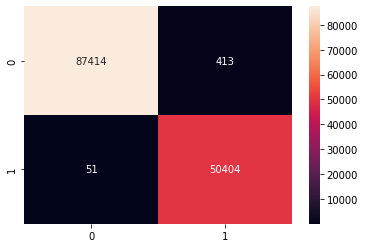

In [ ]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
print("Test Accuracy = {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

#### Logistic Regression

Test Accuracy = 0.863199838012178
              precision    recall  f1-score   support

           0       0.83      0.99      0.90     87827
           1       0.98      0.64      0.77     50455

    accuracy                           0.86    138282
   macro avg       0.90      0.82      0.84    138282
weighted avg       0.88      0.86      0.85    138282



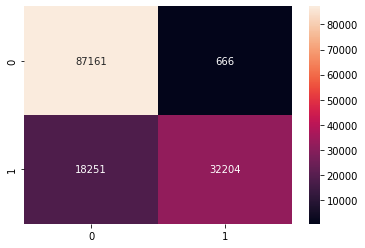

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print("Test Accuracy = {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

#### Gaussian Naive Bayes

Test Accuracy = 0.8484763020494352
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     87827
           1       0.91      0.65      0.76     50455

    accuracy                           0.85    138282
   macro avg       0.87      0.81      0.82    138282
weighted avg       0.86      0.85      0.84    138282



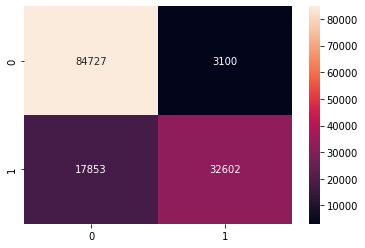

In [ ]:
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)
y_pred = gnb_model.predict(X_test)
print("Test Accuracy = {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

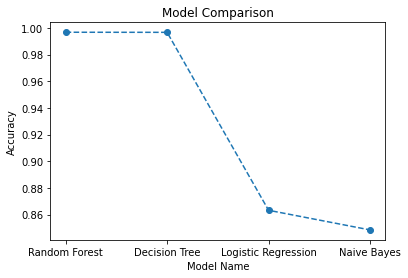

In [32]:
model_names = ['Random Forest', 'Decision Tree', 'Logistic Regression', 'Naive Bayes']
model_accuracy = [0.996716, 0.9966445, 0.8631998, 0.84847630]

plt.plot(model_names, model_accuracy, marker='o', linestyle = '--')
plt.title('Model Comparison')
plt.xlabel('Model Name')
plt.ylabel('Accuracy');

#### Save the best Model

In [ ]:
with open(r'RF_model.pkl','wb') as model_pkl:
  pickle.dump(rf_model, model_pkl, protocol=2)